Произведем импорт необходимых библиотек

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import lightgbm as lgb
import optuna
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#Чтение исходных данных
data_1 = pd.read_csv('sales_raw.csv')
data_2 = pd.read_csv('discounts_raw.csv')

In [3]:
#Посмотрим каким типом данных обладают колонки date_2
data_2.dtypes

item_id                      int64
promo_typeCode             float64
sale_price_before_promo    float64
sale_price_time_promo      float64
date_start                  object
date_end                    object
dtype: object

In [4]:
#Конвертируем тип данных в datetime у колонок 'date_start' и 'date_end'
data_2['date_start'] = pd.to_datetime(data_2['date_start'])
data_2['date_end'] = pd.to_datetime(data_2['date_end'])

Тоже самое сделаем с date_1

In [5]:
data_1.dtypes

date        object
item_id      int64
qnty       float64
dtype: object

In [6]:
data_1['date'] = pd.to_datetime(data_1['date'])

Найдем id товаров, которые продавались в декабре

In [7]:
df_product_december = data_1[(data_1['date']>'2023-11-30')&(data_1['date']<'2024-01-01')]
products_of_dec = df_product_december['item_id'].unique()

In [8]:
products_of_dec

array([100545, 100645, 100683, 100612, 100165, 100611, 100006, 100601,
       100126, 100657, 100035, 100523, 100656, 100604, 100602, 100050,
       100646, 100663, 100558, 100553, 100517, 100448, 100390, 100644,
       100607, 100516, 100486, 100188, 100591, 100556, 100650, 100510,
       100010, 100259, 100192, 100182, 100454, 100193, 100455, 100346,
       100525, 100638, 100544, 100651, 100524, 100551, 100003, 100613,
       100245, 100590, 100354, 100614, 100450,  11200, 100348, 100528,
       100139, 100227, 100257, 100140, 100045, 100469, 100691, 100470,
       100639, 100648, 100621, 100001, 100176, 100228, 100530, 100471,
       100417, 100668, 100596, 100686, 100399, 100554, 100664, 100418,
       100394, 100665, 100487, 100473, 100370, 100547, 100181, 100184,
       100526, 100462, 100453, 100225, 100474, 100386, 100375, 100046,
       100662], dtype=int64)

In [9]:
len(products_of_dec)

97

Разобьем сроки действия акций на каждый день

In [10]:
df = pd.DataFrame()

In [11]:
for i in range(data_2.shape[0]): #Пройдемся по каждому элементу data_2
    start_date = data_2['date_start'].values[i]  # Дата начала акции i-го элемента
    end_date = data_2['date_end'].values[i]    # Дата окончания акции i-го элемента
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    df_temp = pd.DataFrame({'date': date_range})
    item_id = data_2['item_id'].values[i]  # ID i-го элемента
    promo_typeCode = data_2['promo_typeCode'].values[i] # Код промоакции i-го элемента
    sale_price_before_promo = data_2['sale_price_before_promo'].values[i] # Цена до акции i-го элемента
    sale_price_time_promo = data_2['sale_price_time_promo'].values[i] # Цена после акции i-го элемента

    df_temp['item_id'] = item_id
    df_temp['promo_typeCode'] = promo_typeCode
    df_temp['sale_price_before_promo'] = sale_price_before_promo
    df_temp['sale_price_time_promo'] = sale_price_time_promo
    
    df = pd.concat([df, df_temp], ignore_index = True)

In [12]:
df

,date,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo
0,2023-03-02,100551,5.0,159.9,139.9
1,2023-03-03,100551,5.0,159.9,139.9
2,2023-03-04,100551,5.0,159.9,139.9
3,2023-03-05,100551,5.0,159.9,139.9
4,2023-03-06,100551,5.0,159.9,139.9
...,...,...,...,...,...
27441,2023-11-18,100474,5.0,69.9,44.9
27442,2023-11-19,100474,5.0,69.9,44.9
27443,2023-11-20,100474,5.0,69.9,44.9
27444,2023-11-21,100474,5.0,69.9,44.9


Создадим новую колонку с днями недели

In [15]:
df['day_of_week'] = df['date'].dt.dayofweek

Объединим dataframe с данными об акциях и ценах и dataframe с количеством проданных товаров. Объединять будем по date и item_id

In [16]:
df_itog = df.merge(data_1, on = ['date', 'item_id'], how = 'left')

In [19]:
df_itog[df_itog.index == 7696]

,date,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,day_of_week,qnty,year,month,day
7696,2024-01-09,100644,6.0,109.9,79.9,1,NaN,2024,1,9


Преобразуем колонку с датой в отдельные колонки(год, месяц, день)

In [18]:
df_itog['year'] = df_itog['date'].apply(lambda time: time.year)

df_itog['month'] = df_itog['date'].apply(lambda time: time.month)

df_itog['day'] = df_itog['date'].apply(lambda time: time.day)

In [20]:
df_itog

,date,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,day_of_week,qnty,year,month,day
0,2023-03-02,100551,5.0,159.9,139.9,3,3.0,2023,3,2
1,2023-03-03,100551,5.0,159.9,139.9,4,3.0,2023,3,3
2,2023-03-04,100551,5.0,159.9,139.9,5,1.0,2023,3,4
3,2023-03-05,100551,5.0,159.9,139.9,6,5.0,2023,3,5
4,2023-03-06,100551,5.0,159.9,139.9,0,6.0,2023,3,6
...,...,...,...,...,...,...,...,...,...,...
27441,2023-11-18,100474,5.0,69.9,44.9,5,16.0,2023,11,18
27442,2023-11-19,100474,5.0,69.9,44.9,6,12.0,2023,11,19
27443,2023-11-20,100474,5.0,69.9,44.9,0,7.0,2023,11,20
27444,2023-11-21,100474,5.0,69.9,44.9,1,3.0,2023,11,21


Вычислим процент скидки для каждого элемента датафрейма

In [21]:
df_itog['percent_of_discount'] = round((((df_itog['sale_price_before_promo'] - df_itog['sale_price_time_promo'])/df_itog['sale_price_before_promo'])*100), 0)

Уберем все элементы у которых скидка < 0

In [22]:
df_itog = df_itog[df_itog['percent_of_discount']>=0]

Удалим из итогового датафрейма цену до акции и после, а также отсортируем его по дате(по возрастанию)

In [23]:
df_itog = df_itog.drop(['sale_price_before_promo', 'sale_price_time_promo'], axis = 1)

In [24]:
df_itog = df_itog.sort_values(by = ['date'])

In [25]:
df_itog

,date,item_id,promo_typeCode,day_of_week,qnty,year,month,day,percent_of_discount
705,2020-01-02,100448,5.0,3,3.0,2020,1,2,33.0
733,2020-01-02,100638,5.0,3,49.0,2020,1,2,40.0
7490,2020-01-02,100551,7.0,3,7.0,2020,1,2,39.0
18309,2020-01-02,100386,6.0,3,NaN,2020,1,2,24.0
726,2020-01-02,100545,5.0,3,43.0,2020,1,2,38.0
...,...,...,...,...,...,...,...,...,...
8658,2024-02-14,100650,5.0,2,NaN,2024,2,14,27.0
8626,2024-02-14,100473,5.0,2,NaN,2024,2,14,29.0
23062,2024-02-14,100225,5.0,2,NaN,2024,2,14,14.0
20965,2024-02-14,100551,5.0,2,NaN,2024,2,14,0.0


Создадим словарь, в котором будут храниться даты всех праздников с 2020 по 2024 год при помощи библиотеки holidays

In [26]:
ru_holidays = holidays.RU(years = [2020, 2021, 2022, 2023, 2024])

In [27]:
ru_holidays

{datetime.date(2020, 1, 1): 'Новогодние каникулы', datetime.date(2020, 1, 2): 'Новогодние каникулы', datetime.date(2020, 1, 3): 'Новогодние каникулы', datetime.date(2020, 1, 4): 'Новогодние каникулы', datetime.date(2020, 1, 5): 'Новогодние каникулы', datetime.date(2020, 1, 6): 'Новогодние каникулы', datetime.date(2020, 1, 8): 'Новогодние каникулы', datetime.date(2020, 1, 7): 'Рождество Христово', datetime.date(2020, 2, 23): 'День защитника Отечества', datetime.date(2020, 3, 8): 'Международный женский день', datetime.date(2020, 5, 1): 'Праздник Весны и Труда', datetime.date(2020, 5, 9): 'День Победы', datetime.date(2020, 6, 12): 'День России', datetime.date(2020, 11, 4): 'День народного единства', datetime.date(2021, 1, 1): 'Новогодние каникулы', datetime.date(2021, 1, 2): 'Новогодние каникулы', datetime.date(2021, 1, 3): 'Новогодние каникулы', datetime.date(2021, 1, 4): 'Новогодние каникулы', datetime.date(2021, 1, 5): 'Новогодние каникулы', datetime.date(2021, 1, 6): 'Новогодние каник

Создадим колонку, в которой будет храниться информация, о том является ли дата государственным праздником (0-нет, 1-да)

In [28]:
df_itog['is_hol'] = pd.Series(df_itog.index).apply(lambda x:ru_holidays.get(x)).values

In [29]:
df_itog['is_hol'] = df_itog['is_hol'].astype('bool').astype('int')

In [30]:
#Данная функция конвертирует numpy.datetime в pythom.datetime
def to_datetime(date):
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

In [31]:
for i in range(df_itog.shape[0]):
    if to_datetime(df_itog.date.values[i]) in ru_holidays:
        df_itog.is_hol.values[i] = 1
    else:
        df_itog.is_hol.values[i] = 0

In [32]:
df_itog

,date,item_id,promo_typeCode,day_of_week,qnty,year,month,day,percent_of_discount,is_hol
705,2020-01-02,100448,5.0,3,3.0,2020,1,2,33.0,1
733,2020-01-02,100638,5.0,3,49.0,2020,1,2,40.0,1
7490,2020-01-02,100551,7.0,3,7.0,2020,1,2,39.0,1
18309,2020-01-02,100386,6.0,3,NaN,2020,1,2,24.0,1
726,2020-01-02,100545,5.0,3,43.0,2020,1,2,38.0,1
...,...,...,...,...,...,...,...,...,...,...
8658,2024-02-14,100650,5.0,2,NaN,2024,2,14,27.0,0
8626,2024-02-14,100473,5.0,2,NaN,2024,2,14,29.0,0
23062,2024-02-14,100225,5.0,2,NaN,2024,2,14,14.0,0
20965,2024-02-14,100551,5.0,2,NaN,2024,2,14,0.0,0


Удалим колонку с датой, так как она нам больше не нужна

In [33]:
df_itog = df_itog.drop('date', axis = 1)

Разделим итоговый датафрейм на 2:
1. Итоговый датафрейм без января 2024 года
2. Итоговый датафрейм, содержащий данные только о январе 2024 года

In [34]:
df_without_jan24 = df_itog[((df_itog['year']<=2023)&(df_itog['month'] <= 12)) | (df_itog['year']>=2024)&(df_itog['month'] >= 2)]
df_jan24 = df_itog[(df_itog['year']==2024)&(df_itog['month'] == 1)]

Проверим присутствуют ли в df_without_jan24 пустые значения

In [35]:
df_without_jan24.isna().sum()

item_id                   0
promo_typeCode          553
day_of_week               0
qnty                   6313
year                      0
month                     0
day                       0
percent_of_discount       0
is_hol                    0
dtype: int64

Заполним пустые значения при помощи KNN импутера

In [36]:
imputer=KNNImputer(n_neighbors=300, weights = 'distance')
imputer.fit(df_without_jan24)
df_temp = imputer.transform(df_without_jan24)

In [37]:
df_without_jan24_temp = pd.DataFrame(df_temp, columns = df_without_jan24.columns)

In [38]:
df_without_jan24_temp.isna().sum()

item_id                0
promo_typeCode         0
day_of_week            0
qnty                   0
year                   0
month                  0
day                    0
percent_of_discount    0
is_hol                 0
dtype: int64

Округлим полученные значения в promo_typeCode, ведь вещественных типов акций не существует. Для этого была реализована функция, описанная ниже

In [39]:
def round_promo(df):
    for i in range(df.shape[0]):
        rounded_value = round((df['promo_typeCode'].values[i]), 0)
        if rounded_value>= 1 and rounded_value < 2:
            df['promo_typeCode'].values[i] = 1
        elif rounded_value>= 2 and rounded_value < 5:
            df['promo_typeCode'].values[i] = 2
        elif rounded_value>= 5 and rounded_value < 6:
            df['promo_typeCode'].values[i] = 5
        elif rounded_value>= 6 and rounded_value < 7:
            df['promo_typeCode'].values[i] = 6
        elif rounded_value>= 7 and rounded_value < 8:
            df['promo_typeCode'].values[i] = 7
        elif rounded_value>= 8 and rounded_value < 10:
            df['promo_typeCode'].values[i] = 8
        elif rounded_value>= 10 and rounded_value < 16:
            df['promo_typeCode'].values[i] = 10
        elif rounded_value>= 16 and rounded_value < 23:
            df['promo_typeCode'].values[i] = 16
        elif rounded_value>= 23 and rounded_value < 44:
            df['promo_typeCode'].values[i] = 23
        elif rounded_value>= 44:
            df['promo_typeCode'].values[i] = 44
    return df

In [40]:
round_promo(df_without_jan24_temp)

,item_id,promo_typeCode,day_of_week,qnty,year,month,day,percent_of_discount,is_hol
0,100448.0,5.0,3.0,3.000000,2020.0,1.0,2.0,33.0,1.0
1,100638.0,5.0,3.0,49.000000,2020.0,1.0,2.0,40.0,1.0
2,100551.0,7.0,3.0,7.000000,2020.0,1.0,2.0,39.0,1.0
3,100386.0,6.0,3.0,3.007026,2020.0,1.0,2.0,24.0,1.0
4,100545.0,5.0,3.0,43.000000,2020.0,1.0,2.0,38.0,1.0
...,...,...,...,...,...,...,...,...,...
26879,100650.0,5.0,2.0,7.158522,2024.0,2.0,14.0,27.0,0.0
26880,100473.0,5.0,2.0,29.291766,2024.0,2.0,14.0,29.0,0.0
26881,100225.0,5.0,2.0,3.397810,2024.0,2.0,14.0,14.0,0.0
26882,100551.0,5.0,2.0,3.124487,2024.0,2.0,14.0,0.0,0.0


Округлим qnty, так как нельзя продать не целое количество товаров

In [41]:
df_without_jan24_temp.qnty = df_without_jan24_temp.qnty.round()

In [42]:
df_without_jan24 = df_without_jan24_temp

Проверим присутстуют ли пустые значения среди признаков df_jan24, на qnty не смотрим, так как его в итоге нам надо будет предсказать

In [43]:
df_jan24.isna().sum()

item_id                  0
promo_typeCode           0
day_of_week              0
qnty                   540
year                     0
month                    0
day                      0
percent_of_discount      0
is_hol                   0
dtype: int64

Проверим присутствуют ли выбросы в колонке df_without_jan24.qnty. Для этого построим ящик с усами

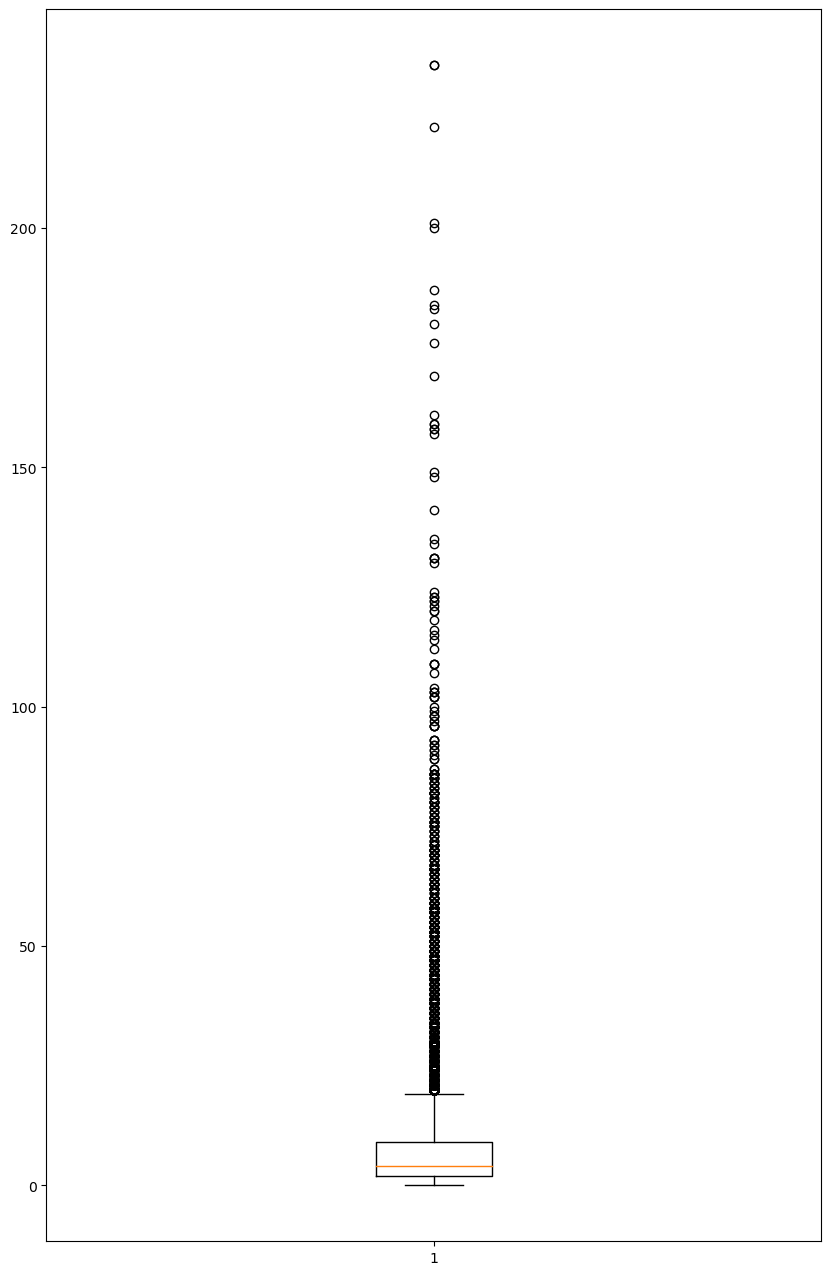

In [44]:
### Your code is here

fig = plt.figure()

fig.set_size_inches((10, 16))

plt.boxplot(df_without_jan24['qnty'].values)

plt.show()

In [45]:
q_low = df_without_jan24['qnty'].quantile(0.25)
q_high = df_without_jan24['qnty'].quantile(0.75)

tentacle_length = q_high - q_low
upper_tentacle = df_without_jan24['qnty'].quantile(0.995)
upper_tentacle

73.0

Выбросы присутвуют, поэтому удалилим все значения, которые больше 99.5% других

In [46]:
df_without_jan24 = df_without_jan24[df_without_jan24['qnty']<upper_tentacle]

Посмотриим на корреляцию между признаками и таргетом тоже в df_without_jan24

<AxesSubplot:>

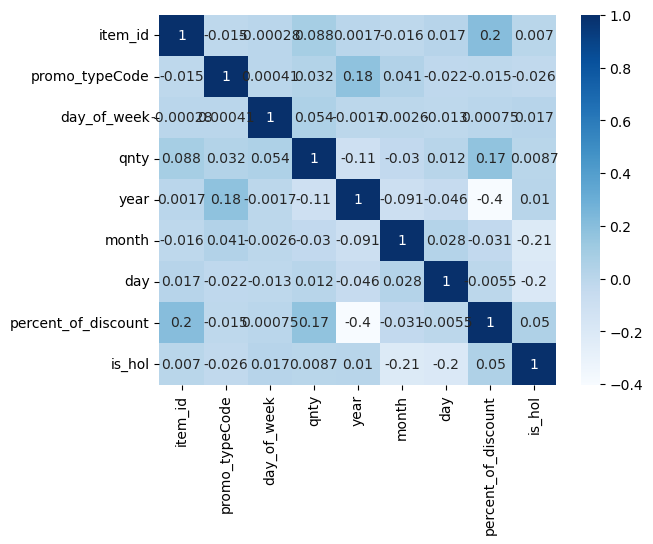

In [47]:
corr = df_without_jan24.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

Разобьем наши данные тестовые(январь 2024), валидационные(ноябрь и декабрь 2023) и тренировочные(2023(без декабря и ноября), 2022, 2021, 2020)

In [48]:
df_test = df_jan24[df_jan24['item_id'].isin(products_of_dec)]

In [49]:
X_test = df_test.drop(['qnty'], axis = 1)

In [50]:
X_test

,item_id,promo_typeCode,day_of_week,year,month,day,percent_of_discount,is_hol
12789,100165,5.0,0,2024,1,1,14.0,1
21770,100390,6.0,0,2024,1,1,29.0,1
22988,100596,6.0,0,2024,1,1,21.0,1
19486,100551,5.0,0,2024,1,1,0.0,1
19503,100516,5.0,0,2024,1,1,0.0,1
...,...,...,...,...,...,...,...,...
12455,100651,6.0,2,2024,1,31,30.0,0
8580,100470,5.0,2,2024,1,31,29.0,0
25273,100664,5.0,2,2024,1,31,27.0,0
25971,100126,5.0,2,2024,1,31,2.0,0


In [51]:
valid_df = df_without_jan24[(df_without_jan24['year'] == 2023) & (df_without_jan24['month'] > 10)]

In [52]:
df_without_jan24.year.unique()

array([2020., 2021., 2022., 2023., 2024.])

In [53]:
train_df = df_without_jan24[((df_without_jan24['year'] == 2023) & (df_without_jan24['month'] <= 10)) | (df_without_jan24['year'] == 2022) | (df_without_jan24['year'] == 2021) | (df_without_jan24['year'] == 2020)]

In [54]:
X_train = train_df.drop('qnty', axis = 1)
y_train = train_df['qnty']

In [55]:
X_valid = valid_df.drop('qnty', axis = 1)
y_valid = valid_df['qnty']

Построим LinearRegression и сравним его со средним y_valid

In [56]:
model = LinearRegression().fit(X_train, y_train)

In [57]:
y_valid.mean()

7.6595310907237515

In [58]:
mean_squared_error(y_valid, model.predict(X_valid), squared=False)

9.418512503594103

Построим KNeighborsRegressor, подберем для него лучшее количество соседей при помощи optuna и сравним его со средним y_valid

In [59]:
neigh = KNeighborsRegressor(n_neighbors=24, weights='distance')
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=24, weights='distance')

In [60]:
mean_squared_error(y_valid, neigh.predict(X_valid), squared=False)

7.652291360167769

In [63]:
def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 100)
    neigh = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')
    neigh.fit(X_train, y_train)
    return mean_squared_error(y_valid, neigh.predict(X_valid), squared=False)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=90)

[I 2024-03-25 13:35:30,741] A new study created in memory with name: no-name-ee12edcf-b455-4a06-8fa8-1e33af3152e8
[I 2024-03-25 13:35:30,842] Trial 0 finished with value: 7.758472780722001 and parameters: {'n_neighbors': 68}. Best is trial 0 with value: 7.758472780722001.
[I 2024-03-25 13:35:30,971] Trial 1 finished with value: 7.7168461523362115 and parameters: {'n_neighbors': 38}. Best is trial 1 with value: 7.7168461523362115.
[I 2024-03-25 13:35:31,054] Trial 2 finished with value: 7.960818119839092 and parameters: {'n_neighbors': 9}. Best is trial 1 with value: 7.7168461523362115.
[I 2024-03-25 13:35:31,162] Trial 3 finished with value: 7.749161185609477 and parameters: {'n_neighbors': 70}. Best is trial 1 with value: 7.7168461523362115.
[I 2024-03-25 13:35:31,287] Trial 4 finished with value: 7.731851409448228 and parameters: {'n_neighbors': 53}. Best is trial 1 with value: 7.7168461523362115.
[I 2024-03-25 13:35:31,363] Trial 5 finished with value: 8.473760146638094 and paramete

[I 2024-03-25 13:35:36,352] Trial 51 finished with value: 7.657070691947595 and parameters: {'n_neighbors': 23}. Best is trial 11 with value: 7.652291360167769.
[I 2024-03-25 13:35:36,430] Trial 52 finished with value: 7.738651404886835 and parameters: {'n_neighbors': 18}. Best is trial 11 with value: 7.652291360167769.
[I 2024-03-25 13:35:36,551] Trial 53 finished with value: 7.670657759886588 and parameters: {'n_neighbors': 32}. Best is trial 11 with value: 7.652291360167769.
[I 2024-03-25 13:35:36,630] Trial 54 finished with value: 8.236872117889042 and parameters: {'n_neighbors': 7}. Best is trial 11 with value: 7.652291360167769.
[I 2024-03-25 13:35:36,767] Trial 55 finished with value: 7.819355025930332 and parameters: {'n_neighbors': 83}. Best is trial 11 with value: 7.652291360167769.
[I 2024-03-25 13:35:36,889] Trial 56 finished with value: 7.827047936031887 and parameters: {'n_neighbors': 14}. Best is trial 11 with value: 7.652291360167769.
[I 2024-03-25 13:35:36,996] Trial 5

In [72]:
study.best_params

{'n_neighbors': 24}

Построим LGBMRegressor, подберем для него гиперпараметры при помощи optuna и сравним его со средним y_valid

In [82]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "dart",
        "n_estimators": trial.suggest_int("n_estimators", 900, 1550),
        "max_depth": trial.suggest_int("max_depth", 1800, 2500),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.7),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 0.5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
        
    }

    model1 = lgb.LGBMRegressor(**params)
    model1.fit(X_train, y_train)
    predictions = model1.predict(X_valid)
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    return rmse

In [83]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

[I 2024-03-25 19:58:03,726] A new study created in memory with name: no-name-4771b34a-9cc7-4acc-aa2a-fe2fef4ad576
[I 2024-03-25 19:58:32,658] Trial 0 finished with value: 6.768478783287903 and parameters: {'n_estimators': 909, 'max_depth': 1902, 'learning_rate': 0.011412755175028702, 'num_leaves': 377, 'subsample': 0.8455906148640597, 'colsample_bytree': 0.470550340649593, 'reg_lambda': 0.10380302151403285, 'min_data_in_leaf': 35}. Best is trial 0 with value: 6.768478783287903.
[I 2024-03-25 19:58:58,219] Trial 1 finished with value: 6.6791708789099875 and parameters: {'n_estimators': 1026, 'max_depth': 2349, 'learning_rate': 0.017399977556180564, 'num_leaves': 319, 'subsample': 0.7990362950179009, 'colsample_bytree': 0.4587365012945875, 'reg_lambda': 0.012956601871831576, 'min_data_in_leaf': 95}. Best is trial 1 with value: 6.6791708789099875.
[I 2024-03-25 19:59:26,608] Trial 2 finished with value: 6.766003774671938 and parameters: {'n_estimators': 1017, 'max_depth': 2043, 'learning_

[I 2024-03-25 20:11:54,609] Trial 22 finished with value: 6.615445314603358 and parameters: {'n_estimators': 1384, 'max_depth': 2432, 'learning_rate': 0.011949099226389944, 'num_leaves': 262, 'subsample': 0.7089886101002554, 'colsample_bytree': 0.6470881970434146, 'reg_lambda': 0.22025809278895922, 'min_data_in_leaf': 29}. Best is trial 4 with value: 6.5395244348864505.
[I 2024-03-25 20:12:40,052] Trial 23 finished with value: 6.6697432960187415 and parameters: {'n_estimators': 1463, 'max_depth': 2288, 'learning_rate': 0.015452291455548382, 'num_leaves': 344, 'subsample': 0.7838883505066515, 'colsample_bytree': 0.5547465601055577, 'reg_lambda': 0.35586572063249367, 'min_data_in_leaf': 65}. Best is trial 4 with value: 6.5395244348864505.
[I 2024-03-25 20:13:15,036] Trial 24 finished with value: 6.643428290859838 and parameters: {'n_estimators': 1156, 'max_depth': 2323, 'learning_rate': 0.013055467911244316, 'num_leaves': 305, 'subsample': 0.6741641874784322, 'colsample_bytree': 0.591049

[I 2024-03-25 20:24:43,025] Trial 45 finished with value: 6.579191399052078 and parameters: {'n_estimators': 1024, 'max_depth': 2027, 'learning_rate': 0.01728363009597769, 'num_leaves': 385, 'subsample': 0.8808906401275012, 'colsample_bytree': 0.6316020294212611, 'reg_lambda': 0.24220085230139873, 'min_data_in_leaf': 10}. Best is trial 4 with value: 6.5395244348864505.
[I 2024-03-25 20:25:18,089] Trial 46 finished with value: 6.535805520650596 and parameters: {'n_estimators': 1377, 'max_depth': 1986, 'learning_rate': 0.02214401810090335, 'num_leaves': 212, 'subsample': 0.8900130904046478, 'colsample_bytree': 0.41712758936678207, 'reg_lambda': 0.2745056346452866, 'min_data_in_leaf': 5}. Best is trial 46 with value: 6.535805520650596.
[I 2024-03-25 20:25:54,321] Trial 47 finished with value: 6.523977255467244 and parameters: {'n_estimators': 1385, 'max_depth': 1990, 'learning_rate': 0.01307910220333707, 'num_leaves': 209, 'subsample': 0.8674115769188167, 'colsample_bytree': 0.42513781270

[I 2024-03-25 20:38:54,567] Trial 67 finished with value: 6.601379980739162 and parameters: {'n_estimators': 1446, 'max_depth': 1835, 'learning_rate': 0.011691969381518506, 'num_leaves': 207, 'subsample': 0.8608454206937751, 'colsample_bytree': 0.42085153605958864, 'reg_lambda': 0.3824093519761309, 'min_data_in_leaf': 26}. Best is trial 62 with value: 6.494416336769992.
[I 2024-03-25 20:39:31,453] Trial 68 finished with value: 6.6118545601621195 and parameters: {'n_estimators': 1340, 'max_depth': 1963, 'learning_rate': 0.01230892628414659, 'num_leaves': 253, 'subsample': 0.8723821349259864, 'colsample_bytree': 0.4052350679761134, 'reg_lambda': 0.33377156478321096, 'min_data_in_leaf': 20}. Best is trial 62 with value: 6.494416336769992.
[I 2024-03-25 20:40:10,777] Trial 69 finished with value: 6.5081083022526105 and parameters: {'n_estimators': 1384, 'max_depth': 1870, 'learning_rate': 0.014523069288017085, 'num_leaves': 243, 'subsample': 0.8503860506476065, 'colsample_bytree': 0.486151

[I 2024-03-25 21:03:39,690] Trial 89 finished with value: 6.54257925710299 and parameters: {'n_estimators': 1404, 'max_depth': 2047, 'learning_rate': 0.013853055789351584, 'num_leaves': 260, 'subsample': 0.8708816509579141, 'colsample_bytree': 0.4454451326243106, 'reg_lambda': 0.32214595543923197, 'min_data_in_leaf': 11}. Best is trial 62 with value: 6.494416336769992.
[I 2024-03-25 21:04:34,262] Trial 90 finished with value: 6.5131296991487 and parameters: {'n_estimators': 1500, 'max_depth': 1863, 'learning_rate': 0.01267889688711466, 'num_leaves': 294, 'subsample': 0.8896702518424536, 'colsample_bytree': 0.40144722638920094, 'reg_lambda': 0.3072644893251914, 'min_data_in_leaf': 14}. Best is trial 62 with value: 6.494416336769992.
[I 2024-03-25 21:05:24,857] Trial 91 finished with value: 6.536210275353972 and parameters: {'n_estimators': 1499, 'max_depth': 1846, 'learning_rate': 0.01269467821471054, 'num_leaves': 223, 'subsample': 0.8917481242687494, 'colsample_bytree': 0.407919667623

[I 2024-03-25 21:23:06,851] Trial 111 finished with value: 6.523630431738793 and parameters: {'n_estimators': 1399, 'max_depth': 1852, 'learning_rate': 0.013325359978759267, 'num_leaves': 323, 'subsample': 0.8846470489076093, 'colsample_bytree': 0.4171690175210685, 'reg_lambda': 0.32872751694550983, 'min_data_in_leaf': 20}. Best is trial 62 with value: 6.494416336769992.
[I 2024-03-25 21:23:57,348] Trial 112 finished with value: 6.563344604311508 and parameters: {'n_estimators': 1371, 'max_depth': 1800, 'learning_rate': 0.013342489030200598, 'num_leaves': 340, 'subsample': 0.8998868678868887, 'colsample_bytree': 0.41237657405350125, 'reg_lambda': 0.3489057057399533, 'min_data_in_leaf': 21}. Best is trial 62 with value: 6.494416336769992.
[I 2024-03-25 21:24:48,793] Trial 113 finished with value: 6.500349707457045 and parameters: {'n_estimators': 1396, 'max_depth': 1892, 'learning_rate': 0.014671648116432547, 'num_leaves': 330, 'subsample': 0.881507662617918, 'colsample_bytree': 0.40686

[I 2024-03-25 21:42:37,281] Trial 133 finished with value: 6.501917330625025 and parameters: {'n_estimators': 1523, 'max_depth': 1853, 'learning_rate': 0.016410071288120803, 'num_leaves': 306, 'subsample': 0.8622106589265001, 'colsample_bytree': 0.4285399467845178, 'reg_lambda': 0.4130152131633709, 'min_data_in_leaf': 10}. Best is trial 124 with value: 6.482924718740242.
[I 2024-03-25 21:43:33,051] Trial 134 finished with value: 6.475948394823879 and parameters: {'n_estimators': 1517, 'max_depth': 1849, 'learning_rate': 0.01719884053246274, 'num_leaves': 306, 'subsample': 0.8622280555866536, 'colsample_bytree': 0.4273469046072869, 'reg_lambda': 0.4119626422492359, 'min_data_in_leaf': 9}. Best is trial 134 with value: 6.475948394823879.
[I 2024-03-25 21:44:30,055] Trial 135 finished with value: 6.554167073832532 and parameters: {'n_estimators': 1550, 'max_depth': 1844, 'learning_rate': 0.016622339653849672, 'num_leaves': 306, 'subsample': 0.8401971414711673, 'colsample_bytree': 0.427258

In [84]:
study.best_params

{'n_estimators': 1481,
 'max_depth': 1887,
 'learning_rate': 0.015837350734304038,
 'num_leaves': 284,
 'subsample': 0.8678824887669903,
 'colsample_bytree': 0.424078697304595,
 'reg_lambda': 0.3640316252360385,
 'min_data_in_leaf': 18}

In [61]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "dart",
    "verbosity": -1,
    "bagging_freq": 1,
    'n_estimators': 1481,
    'max_depth': 1887,
    'learning_rate': 0.015837350734304038,
    'num_leaves': 284,
    'subsample': 0.8678824887669903,
    'colsample_bytree': 0.424078697304595,
    'reg_lambda': 0.3640316252360385,
    'min_data_in_leaf': 18}
model1 = lgb.LGBMRegressor(**params)
model1.fit(X_train, y_train)
predictions = model1.predict(X_valid)
rmse = mean_squared_error(y_valid, predictions, squared=False)
rmse

6.471724690456454

LGBMRegressor показал наилучшее качество, поэтому проверим не переобучилась ли наша модель

In [62]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "dart",
    'n_estimators': 1481,
    'max_depth': 1887,
    "verbosity": -1,
    "bagging_freq": 1,
    'learning_rate': 0.015837350734304038,
    'num_leaves': 284,
    'subsample': 0.8678824887669903,
    'colsample_bytree': 0.424078697304595,
    'reg_lambda': 0.3640316252360385,
    'min_data_in_leaf': 18}
model1 = lgb.LGBMRegressor(**params)
model1.fit(X_train, y_train)
predictions = model1.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
rmse

4.869691319163483

In [63]:
y_train.mean()

7.424833247819395

Нет, наша модель не переобучилась

Оценим Feature Importance

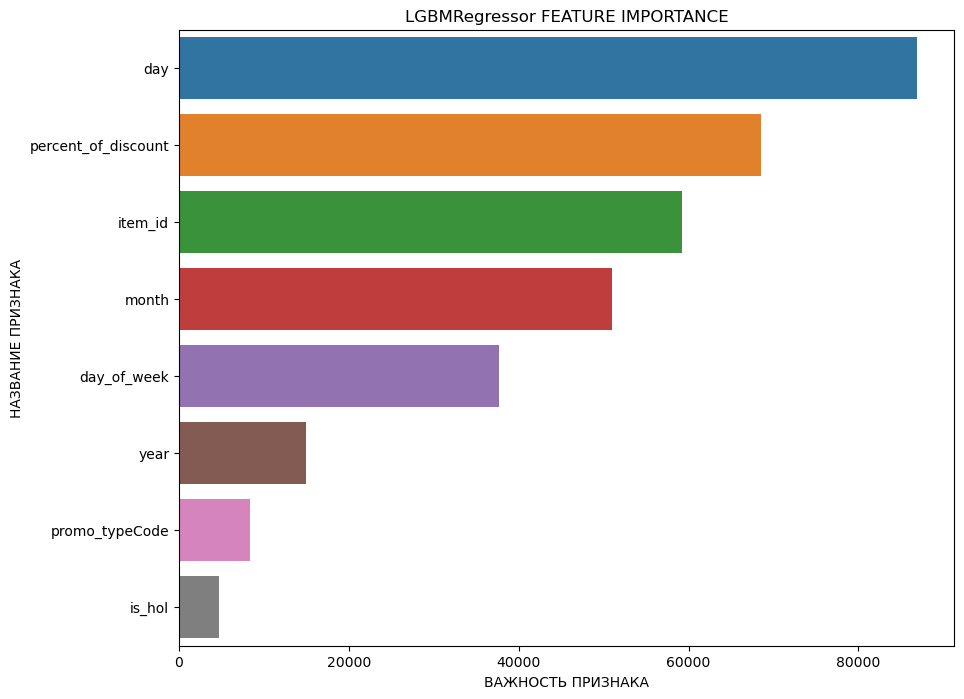

In [64]:
### Из любопытства посмотрим на feature_importance

def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('ВАЖНОСТЬ ПРИЗНАКА')
    plt.ylabel('НАЗВАНИЕ ПРИЗНАКА')

plot_feature_importance(model1.feature_importances_,X_train.columns,'LGBMRegressor')

Исходя из вышенарисованного графика можно сделать вывод, что больше всего повлияли колонки day и percent_of_discount

Сделаем выгрузку предсказаний

In [65]:
predictions_test = model1.predict(X_test)

In [66]:
predictions_test = pd.Series(predictions_test)

In [67]:
predictions_test

0      26.208462
1       2.153438
2       5.114998
3       5.307383
4      14.991370
         ...    
521     3.012286
522    14.394386
523     3.015823
524     2.420086
525    10.413499
Length: 526, dtype: float64

In [72]:
tmp_X_test = X_test.reset_index(drop=True)

In [71]:
X_test

,item_id,promo_typeCode,day_of_week,year,month,day,percent_of_discount,is_hol
12789,100165,5.0,0,2024,1,1,14.0,1
21770,100390,6.0,0,2024,1,1,29.0,1
22988,100596,6.0,0,2024,1,1,21.0,1
19486,100551,5.0,0,2024,1,1,0.0,1
19503,100516,5.0,0,2024,1,1,0.0,1
...,...,...,...,...,...,...,...,...
12455,100651,6.0,2,2024,1,31,30.0,0
8580,100470,5.0,2,2024,1,31,29.0,0
25273,100664,5.0,2,2024,1,31,27.0,0
25971,100126,5.0,2,2024,1,31,2.0,0


In [86]:
test_itog = pd.concat([tmp_X_test, predictions_test], axis = 1)

In [90]:
test_itog

,item_id,promo_typeCode,day_of_week,year,month,day,percent_of_discount,is_hol,prediction
0,100165,5.0,0,2024,1,1,14.0,1,26.208462
1,100390,6.0,0,2024,1,1,29.0,1,2.153438
2,100596,6.0,0,2024,1,1,21.0,1,5.114998
3,100551,5.0,0,2024,1,1,0.0,1,5.307383
4,100516,5.0,0,2024,1,1,0.0,1,14.991370
...,...,...,...,...,...,...,...,...,...
521,100651,6.0,2,2024,1,31,30.0,0,3.012286
522,100470,5.0,2,2024,1,31,29.0,0,14.394386
523,100664,5.0,2,2024,1,31,27.0,0,3.015823
524,100126,5.0,2,2024,1,31,2.0,0,2.420086


In [89]:
test_itog.rename(columns={0:"prediction"}, inplace=True)

In [97]:
test_itog.to_csv('predictions.csv', sep = ';', index = False)